In [2]:
import pandas as pd 
import seaborn as sns
import numpy as np 
import pymc3 as pm 
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('../data/Covid-19 SG Clean.csv')
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
data = data.sort_values('Date')

In [4]:
new_cases = data['Daily Confirmed '].values
len_observed = len(new_cases)

In [5]:
start_id = 66

local_cases = data['Daily Local transmission'].values[start_id:]
imported_cases = data['Daily Imported'].values[start_id:]
len_observed = len(local_cases)
print(len_observed)

432


In [6]:
local_only_cases = data['Local cases not residing in doms MOH report'].values[start_id:]
dorm_only_cases = data['Local cases residing in dorms MOH report'].values[start_id:]

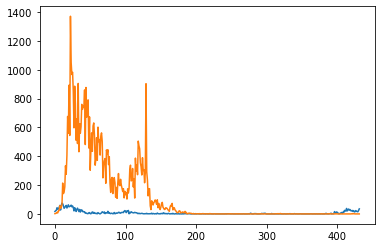

In [7]:
plt.plot(local_only_cases)
plt.plot(dorm_only_cases)

### NPI Covariates

In [8]:
NPIS_proc = pd.read_csv('data/NPIS_LC_processed.csv')
NPIS_wanted = NPIS_proc.iloc[start_id:, 1::]

In [9]:
npi_series = data['Phase'].iloc[start_id:]
values_in_npi = npi_series.unique()

def check_nan(vals):
    for v in vals:
        if pd.isna(v):
            return True
    return False

if check_nan(values_in_npi):
    # NaN should be the base grou
    converted_npi =  pd.get_dummies(npi_series)
    print("None set as base class")

else:
    converted_npi = pd.get_dummies(npi_series)
    remove_var = converted_npi.columns[0]
    converted_npi = converted_npi.iloc[:,1:]
    print(remove_var + " set as base class")

None set as base class


# Singapore Testing Data from OWID

In [10]:
owid = pd.read_csv('../Data/owid-covid-data.csv')
singapore_testing = owid[owid['location']=='Singapore']
singapore_testing = singapore_testing[~singapore_testing['total_tests'].isna()][['date',
                                                                                 'total_tests',
                                                                                 'new_tests',
                                                                                 'positive_rate',
                                                                                 'tests_per_case']]

In [11]:
singapore_testing['test_done_in_week'] = singapore_testing['total_tests'].diff()
singapore_testing['average_test_daily'] = singapore_testing['test_done_in_week']/7.0

In [12]:
singapore_testing.tail()

,date,total_tests,new_tests,positive_rate,tests_per_case,test_done_in_week,average_test_daily
77579,2021-05-17,11064019.0,NaN,0.000,2647.8,622217.0,88888.142857
77586,2021-05-24,11470986.0,NaN,0.001,1647.6,406967.0,58138.142857
77593,2021-05-31,11947790.0,NaN,0.000,2496.3,476804.0,68114.857143
77600,2021-06-07,12366898.0,NaN,0.000,2636.0,419108.0,59872.571429
77607,2021-06-14,12809152.0,NaN,0.000,4859.9,442254.0,63179.142857


In [13]:
daily_dt_range = pd.date_range(start=singapore_testing['date'].iloc[0], end=singapore_testing['date'].iloc[-1])

In [14]:
singapore_testing_daily = singapore_testing.set_index('date')
singapore_testing_daily.index = pd.to_datetime(singapore_testing_daily.index)
singapore_testing_daily = singapore_testing_daily.reindex(daily_dt_range)

In [15]:
singapore_testing_daily['average_test_daily'] = singapore_testing_daily['average_test_daily'].bfill()

In [16]:
singapore_testing_daily = singapore_testing_daily.reset_index()
singapore_testing_daily = singapore_testing_daily.rename({'index':'Date'},axis=1)

In [17]:
singapore_testing_daily

,Date,total_tests,new_tests,positive_rate,tests_per_case,test_done_in_week,average_test_daily
0,2020-04-07,72680.0,NaN,NaN,NaN,NaN,3159.428571
1,2020-04-08,NaN,NaN,NaN,NaN,NaN,3159.428571
2,2020-04-09,NaN,NaN,NaN,NaN,NaN,3159.428571
3,2020-04-10,NaN,NaN,NaN,NaN,NaN,3159.428571
4,2020-04-11,NaN,NaN,NaN,NaN,NaN,3159.428571
...,...,...,...,...,...,...,...
429,2021-06-10,NaN,NaN,NaN,NaN,NaN,63179.142857
430,2021-06-11,NaN,NaN,NaN,NaN,NaN,63179.142857
431,2021-06-12,NaN,NaN,NaN,NaN,NaN,63179.142857
432,2021-06-13,NaN,NaN,NaN,NaN,NaN,63179.142857


In [18]:
data = data.merge(singapore_testing_daily[['Date','test_done_in_week','average_test_daily','positive_rate']],
                  on='Date',
                  how='left')

In [19]:
data['Daily_Positive_Rate_Estimate'] = data['Daily Confirmed ']/ data['average_test_daily']

<AxesSubplot:xlabel='Date'>

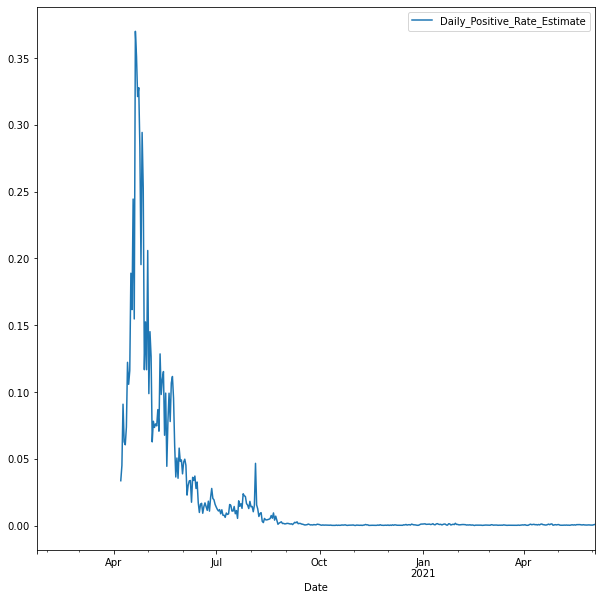

In [20]:
data.plot(x='Date', y='Daily_Positive_Rate_Estimate', figsize=(10,10))


<AxesSubplot:xlabel='Date'>

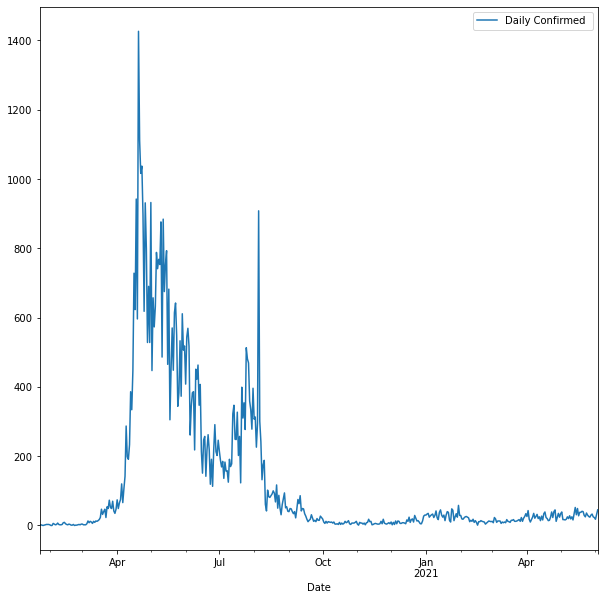

In [21]:
data.plot(x='Date',y='Daily Confirmed ', figsize=(10,10))

# Local Case Models

In [22]:
from scipy import stats as sps

def _get_generation_time_interval():
    """ Create a discrete P(Generation Interval)
        Source: https://www.ijidonline.com/article/S1201-9712(20)30119-3/pdf """
    mean_si = 4.7
    std_si = 2.9
    mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
    sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
    dist = sps.lognorm(scale=np.exp(mu_si), s=sigma_si)

    # Discretize the Generation Interval up to 20 days max
    g_range = np.arange(0, 20)
    gt = pd.Series(dist.cdf(g_range), index=g_range)
    gt = gt.diff().fillna(0)
    gt /= gt.sum()
    gt = gt.values
    return gt

def _get_convolution_ready_gt(len_observed):
    """ Speeds up theano.scan by pre-computing the generation time interval
        vector. Thank you to Junpeng Lao for this optimization.
        Please see the outbreak simulation math here:
        https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html """
    gt = _get_generation_time_interval()
    convolution_ready_gt = np.zeros((len_observed - 1, len_observed))
    for t in range(1, len_observed):
        begin = np.maximum(0, t - len(gt) + 1)
        slice_update = gt[1 : t - begin + 1][::-1]
        convolution_ready_gt[
            t - 1, begin : begin + len(slice_update)
        ] = slice_update
    convolution_ready_gt = theano.shared(convolution_ready_gt)
    return convolution_ready_gt


In [23]:
from covid.patients import get_delay_distribution, get_delays_from_patient_data, download_patient_data
from theano.tensor.signal.conv import conv2d

In [24]:
x = get_delay_distribution()

In [25]:

delays = get_delays_from_patient_data(file_path='data/latestdata.csv')

In [26]:
INCUBATION_DAYS = 5

p_delay = delays.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max() + 1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()
p_delay = (
    pd.Series(0.0001*np.ones(INCUBATION_DAYS))
    .append(p_delay, ignore_index=True)
    .rename("p_delay")
)

In [27]:
def conv(infections, p_delay, len_p_delay, len_observed):
    "1D Convolution of a and b"
    from theano.tensor.signal.conv import conv2d
    return conv2d(
            tt.reshape(infections, (1, len_observed)),
            tt.reshape(p_delay, (1, len_p_delay)),
            border_mode='full',
            )[0, :len_observed]


In [28]:
p_delay_local = p_delay

In [29]:
# 3 incubation days + 5 days onsert
p_delay_dorm = np.array([0.0001, 0.0001, 0.0001, 0.1, 0.2, 0.4, 0.2, 0.1])

# Random Process Prior on R_t + Generation Time Dist + Onset Delay Dist + Adjusting Tests Performed + Imported Cases

In [30]:
imported_cases = data['Daily Imported'].values[start_id:]

# Model 11 - Model 10 but with NPIs

In [31]:
print("Length import Cases: ",len(imported_cases))
print("Length local Cases: ", len(local_cases))

prediction_t = 10 # Days
end_date = 115

train_local_cases = local_cases[0:end_date]
train_imported_cases = imported_cases[0:end_date]

actual = local_cases[end_date:end_date+prediction_t]

train_pad = [np.nan for x in range(prediction_t)]
imported_pad = [train_imported_cases[-1] for x in range(prediction_t)]

model_input = pd.Series(np.concatenate([train_local_cases, train_pad]))
imported_input = np.concatenate([train_imported_cases, imported_pad])

print("Length training cases: ", len(train_local_cases))
print("Length into model: ", len(model_input)," ",len(imported_input))

len_observed = len(model_input)

Length import Cases:  432
Length local Cases:  432
Length training cases:  115
Length into model:  125   125


In [32]:
NPIS_proc = pd.read_csv('data/NPIS_LC_processed.csv')
NPIS_wanted = NPIS_proc.iloc[start_id:, 1::]

In [33]:
NPIS_array = NPIS_wanted.iloc[0:end_date+prediction_t]
NPIS_array.loc[NPIS_array['Gathering_Max']==150,'Gathering_Max'] = 10
NPIS_array = NPIS_array.values
#num_NPIS = NPIS_array.shape[1]
print(NPIS_array.shape)

(125, 11)


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


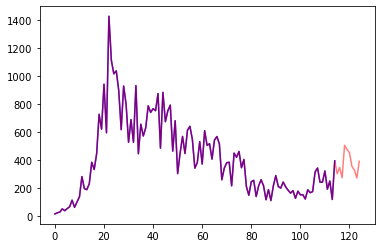

In [34]:
plt.plot(train_local_cases, c='b')
plt.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5)

In [93]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_11:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    beta_list = []
    for i in range(num_NPIS):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = pm.math.dot(np.array(NPIS_array), betas)
    
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_input)],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0)
    """
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    """
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=test_adjusted_positive_jittered,
                  observed=model_input)
    
    trace_11 = pm.sample(chains=2, tune=1500, draws=3000,nuts={'target_accept':0.99})#, target_accept=0.99)

TypeError: conv() missing 1 required positional argument: 'len_observed'

#### Model 11 Analysis

In [675]:
_, n_traces = trace_11['Obs_missing'].T.shape
temp_dates = np.arange(end_date, end_date+prediction_t).reshape(-1,1)
temp_dates = np.tile(temp_dates,n_traces)

In [676]:
with model_11:
    ppc_11 = pm.sample_posterior_predictive(
        trace_11, random_seed=123)

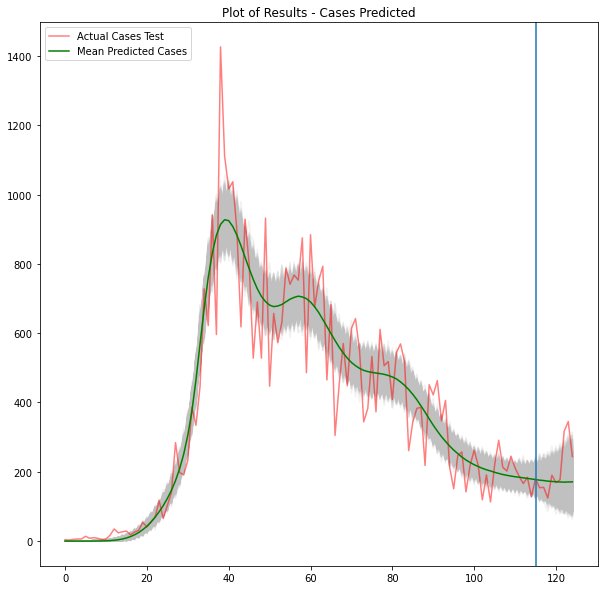

In [677]:
fig, ax = plt.subplots(figsize=(10,10))

#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax.plot(ppc_11['Obs'].T, c='silver', alpha=0.2)

ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5, label='Actual Cases Test')
ax.plot(ppc_11['Obs'].mean(0), c='g', alpha=1, label='Mean Predicted Cases')
ax.axvline(x=end_date)
ax.set_title("Plot of Results - Cases Predicted")
ax.legend()
plt.show()

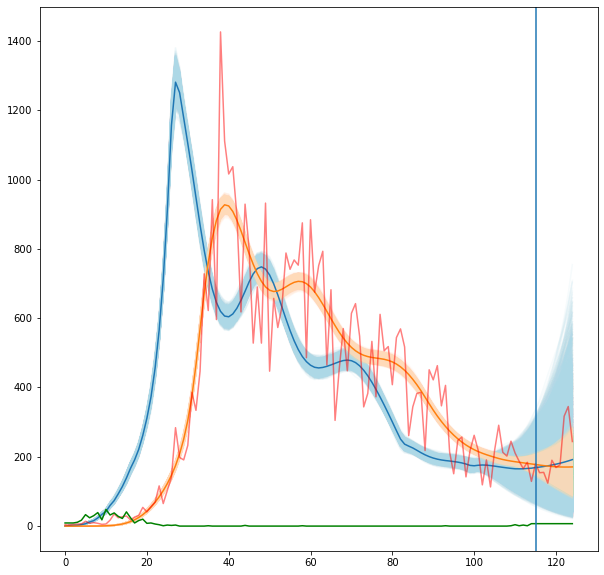

In [678]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_11['infections'].T, c='lightblue', alpha=0.1)
ax.plot(trace_11['test_adjusted_positive_jit'].T, c='peachpuff', alpha=0.1)
ax.plot(trace_11['infections'].mean(0))
ax.plot(trace_11['test_adjusted_positive_jit'].mean(0))
ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5)
ax.plot(imported_input, c='g')
ax.axvline(x=end_date)

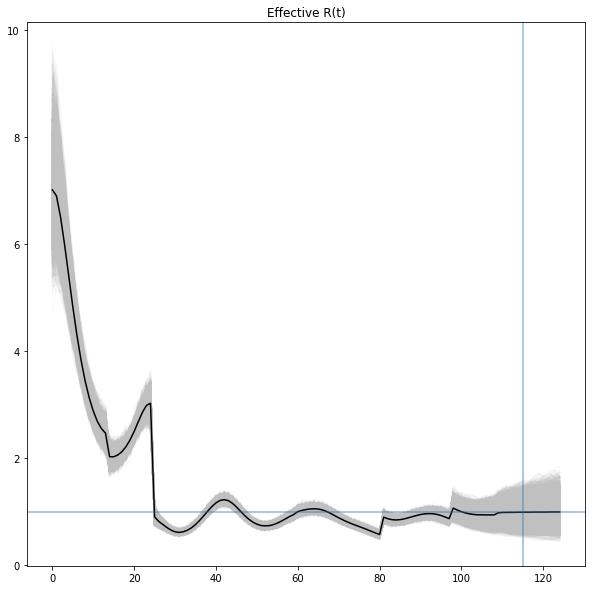

In [679]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_11['r_t'].T, c='silver', alpha=0.1)
ax.plot(trace_11['r_t'].mean(0), c='black', alpha=1)
ax.axhline(y=1, alpha=0.5)
ax.axvline(x=end_date, alpha=0.5)
ax.set_title("Effective R(t)")
plt.show()

In [680]:
trace_11.varnames

['log_r_t',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'b_6',
 'b_7',
 'b_8',
 'b_9',
 'log_eps_t',
 'eps_t_logodds__',
 'Seed_log__',
 'Obs_missing',
 'r_t',
 'eps_t',
 'Seed',
 'infections',
 'test adjusted positive',
 'test_adjusted_positive_jit']

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


[]

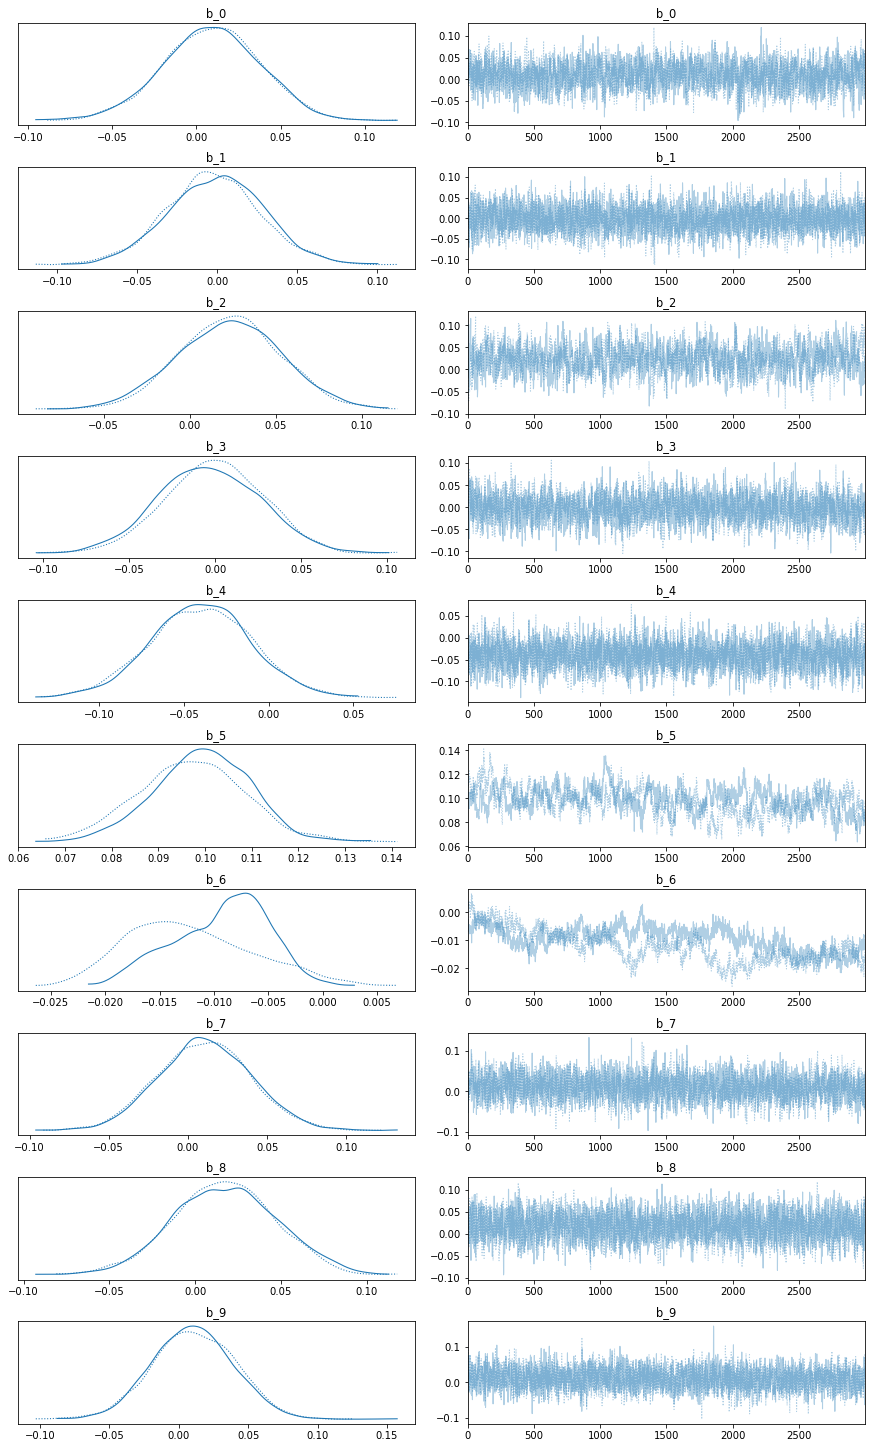

In [681]:
az.plot_trace(trace_11,var_names=['b_'+str(x) for x in range(10)])
plt.plot()

In [682]:
dict(zip(list(NPIS_wanted.columns),['b_'+str(x) for x in range(10)]))

{'Compulsory_Mask': 'b_0',
 'Eat_In_Ban': 'b_1',
 'Entry_Recording': 'b_2',
 'Lockdown': 'b_3',
 'Sch_Closure': 'b_4',
 'Gathering_Max': 'b_5',
 'Mall_Distancing': 'b_6',
 'Recreation': 'b_7',
 'Workplace_Closure': 'b_8',
 'Worship': 'b_9'}

In [683]:
az.summary(trace_11,var_names=['b_'+str(x) for x in range(10)])

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_0,0.009,0.029,-0.044,0.064,0.001,0.001,1386.0,2704.0,1.00
b_1,-0.001,0.030,-0.061,0.052,0.001,0.000,2941.0,3642.0,1.00
b_2,0.023,0.030,-0.032,0.079,0.001,0.001,688.0,1501.0,1.00
b_3,-0.002,0.029,-0.057,0.052,0.001,0.001,1363.0,3110.0,1.00
b_4,-0.040,0.030,-0.096,0.016,0.001,0.000,2133.0,3559.0,1.00
b_5,0.098,0.011,0.076,0.117,0.003,0.002,13.0,134.0,1.13
b_6,-0.011,0.005,-0.020,-0.001,0.002,0.002,5.0,29.0,1.34
b_7,0.011,0.029,-0.046,0.063,0.001,0.000,2401.0,3890.0,1.00
b_8,0.017,0.030,-0.036,0.076,0.000,0.000,3757.0,4676.0,1.00
b_9,0.011,0.029,-0.044,0.064,0.001,0.000,2148.0,4287.0,1.01


# Model 12 - Model 10 / 11 without prediction just to see whether same

In [35]:
print("Length import Cases: ",len(imported_cases))
print("Length local Cases: ", len(local_cases))

prediction_t = 0 # Days
end_date = 115

train_local_cases = local_cases[0:end_date]
train_imported_cases = imported_cases[0:end_date]

actual = local_cases[end_date:end_date+prediction_t]

train_pad = [np.nan for x in range(prediction_t)]
imported_pad = [train_imported_cases[-1] for x in range(prediction_t)]

model_input = pd.Series(np.concatenate([train_local_cases, train_pad]))
imported_input = np.concatenate([train_imported_cases, imported_pad])

print("Length training cases: ", len(train_local_cases))
print("Length into model: ", len(model_input)," ",len(imported_input))

len_observed = len(model_input)

NPIS_array = NPIS_wanted.iloc[0:end_date+prediction_t]
NPIS_array.loc[NPIS_array['Gathering_Max']==150,'Gathering_Max'] = 10
NPIS_array = NPIS_array.values
#num_NPIS = NPIS_array.shape[1]
print(NPIS_array.shape)

Length import Cases:  432
Length local Cases:  432
Length training cases:  115
Length into model:  115   115
(115, 11)


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [95]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_12:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    beta_list = []
    for i in range(num_NPIS):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = pm.math.dot(np.array(NPIS_array), betas)
    
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_input)],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0)
    """
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    """
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=test_adjusted_positive_jittered,
                  observed=model_input)
    
    trace_12 = pm.sample(chains=2,
                         tune=2000,
                         draws=4000,
                         target_accept=0.99,
                         init="adapt_diag"
                        )#,nuts={'target_accept':0.99})#, target_accept=0.99)

TypeError: conv() missing 1 required positional argument: 'len_observed'

In [724]:
_, n_traces = trace_11['Obs_missing'].T.shape
temp_dates = np.arange(end_date, end_date+prediction_t).reshape(-1,1)
temp_dates = np.tile(temp_dates,n_traces)

In [725]:
with model_12:
    ppc_12 = pm.sample_posterior_predictive(
        trace_12, random_seed=123)

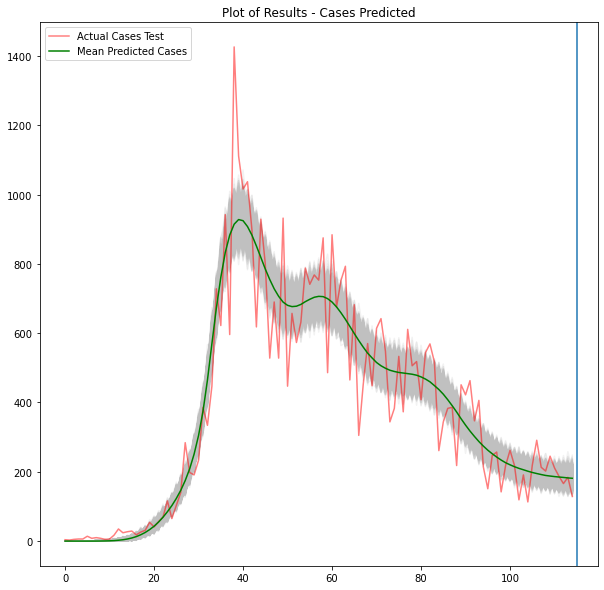

In [726]:
fig, ax = plt.subplots(figsize=(10,10))

#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax.plot(ppc_12['Obs'].T, c='silver', alpha=0.2)

ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5, label='Actual Cases Test')
ax.plot(ppc_12['Obs'].mean(0), c='g', alpha=1, label='Mean Predicted Cases')
ax.axvline(x=end_date)
ax.set_title("Plot of Results - Cases Predicted")
ax.legend()
plt.show()

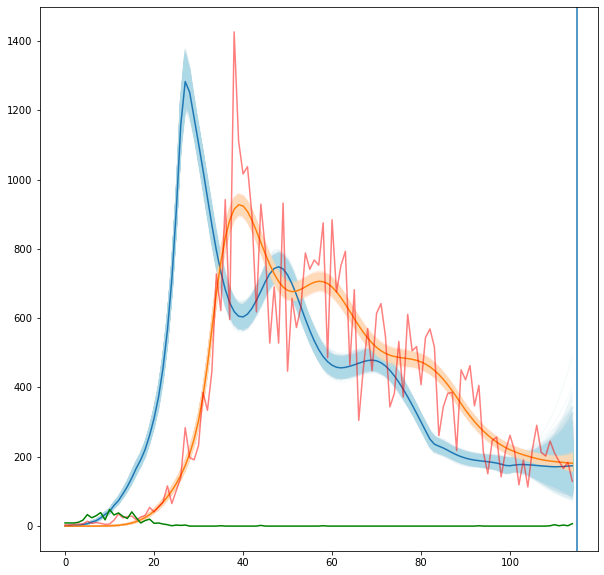

In [727]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_12['infections'].T, c='lightblue', alpha=0.1)
ax.plot(trace_12['test_adjusted_positive_jit'].T, c='peachpuff', alpha=0.1)
ax.plot(trace_12['infections'].mean(0))
ax.plot(trace_12['test_adjusted_positive_jit'].mean(0))
ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5)
ax.plot(imported_input, c='g')
ax.axvline(x=end_date)

# Model 12.5
- Hierarchical Effects (need to recode NPIs first)
- Sum to become a lockdown index

In [ ]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_12:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    # Hierarchical beta
    beta_hier = pm.Normal('mean_beta',0,1)
    beta_var = pm.InverseGamma()
    
    
    beta_list = []
    for i in range(num_NPIS):
        beta_var = pm.Normal(f"b_{i}", 0, sigma=0.03)  # Change to reparamatization!
        beta_list.append(beta_var)
    betas = pm.math.stack(beta_list, 0)
    #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = pm.math.dot(np.array(NPIS_array), betas)
    
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_input)],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0)
    """
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    """
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=test_adjusted_positive_jittered,
                  observed=model_input)
    
    # Gamma trick for continuous to discrete, Gamma -> poisson (like gumbel -> categorical)
    
    trace_12 = pm.sample(chains=2,
                         tune=2000,
                         draws=4000,
                         target_accept=0.99,
                         init="adapt_diag"
                        )#,nuts={'target_accept':0.99})#, target_accept=0.99)

In [65]:
trace12.varnames

NameError: name 'trace12' is not defined

# Model 13 
- First model with separate infected populations for dormitory cases as well as community cases
- Two ideas: 
- Mechanistic combination for hsraing of information
- Typical hierachical pooling of coefficient weights etc -> such as r_t

In [36]:
print("Length import Cases: ",len(imported_cases))
print("Length local Non Dorm Cases: ", len(local_only_cases))
print("Length Dorm Cases: ", len(dorm_only_cases))

prediction_t = 7 # Days
end_date = 115

train_local_only_cases = local_only_cases[0:end_date]
train_dorm_only_cases = dorm_only_cases[0:end_date]
train_imported_cases = imported_cases[0:end_date]

actual_local_only = local_only_cases[end_date:end_date+prediction_t]
actual_dorm_only = dorm_only_cases[end_date:end_date+prediction_t]

train_pad = [np.nan for x in range(prediction_t)]
imported_pad = [train_imported_cases[-1] for x in range(prediction_t)]

model_input_local_only = pd.Series(np.concatenate([train_local_only_cases, train_pad]))
model_input_dorm_only = pd.Series(np.concatenate([train_dorm_only_cases, train_pad]))
imported_input = np.concatenate([train_imported_cases, imported_pad])

print("Length training cases - Local: ", len(train_local_only_cases))
print("Length training cases - Dorm: ", len(train_dorm_only_cases))
print("Length into model: ", len(model_input_local_only)," ",len(model_input_dorm_only)," ",len(imported_input))

len_observed = len(model_input_local_only)

NPIS_array = NPIS_wanted.iloc[0:end_date+prediction_t]
NPIS_array.loc[NPIS_array['Gathering_Max']==150,'Gathering_Max'] = 10
NPIS_array = NPIS_array.values
num_NPIS = NPIS_array.shape[1]
print(NPIS_array.shape)

Length import Cases:  432
Length local Non Dorm Cases:  432
Length Dorm Cases:  432
Length training cases - Local:  115
Length training cases - Dorm:  115
Length into model:  122   122   122
(122, 11)


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [37]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

In [117]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_12:
    
    # R_t Foreign
    log_r_t_foreign = pm.GaussianRandomWalk(
        'log_r_t_foreign',
        sigma=0.035,
        shape=len_observed)
    
    # R_t Local
    log_r_t_local = pm.GaussianRandomWalk(
        'log_r_t_local',
        sigma=0.035,
        shape=len_observed)
    
    
    # NPI Covariates
    beta_list = []
    for i in range(num_NPIS):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = pm.math.dot(np.array(NPIS_array), betas)
    
    
    # Form r_t as GRW + covariates
    r_t_foreign = pm.Deterministic('r_t_foreign', pm.math.exp(log_r_t_foreign + rt_covariates))
    r_t_local = pm.Deterministic('r_t_local', pm.math.exp(log_r_t_local + rt_covariates))
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    
    # Infection Latent Dormitory
    seed_dorm = pm.Exponential('Seed_dorm', 150)  # Scale of infection will be small (Dorm cases started at 0)
    y0_dorm = tt.zeros(len_observed)
    y0_dorm = tt.set_subtensor(y0_dorm[0], seed_dorm)
    # Apply recursively to populate tensor
    outputs_dorm, _ = theano.scan(
            fn=lambda t, gt , y, r_t_foreign: tt.set_subtensor(y[t], tt.sum(r_t_foreign*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0_dorm,
            non_sequences=r_t_foreign,
            n_steps=len_observed-1,
    )
    infections_dorm = pm.Deterministic('infections_dorm', outputs_dorm[-1])
    
    # Infection Latent Local only
    seed = pm.Exponential('Seed_local', 1)  # Scale of infection will be small (Local cases were quite high already)
    y0_local = tt.zeros(len_observed)
    y0_local = tt.set_subtensor(y0_local[0], seed)
    # Apply recursively to populate tensor
    outputs_local, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t_local: tt.set_subtensor(y[t], tt.sum(r_t_local*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_input)],
            outputs_info=y0_local,
            non_sequences=r_t_local,
            n_steps=len_observed-1,
    )
    
    infections_local = pm.Deterministic('infections_local', outputs_local[-1])
    
    
    
    # Onset - Delay Dist - Local
    t_p_delay_local = pm.Data("p_delay_local", p_delay_local)
    
    # Onset - Delay Dist - Dorm
    t_p_delay_dorm = pm.Data("p_delay_dorm", pd.Series(p_delay_dorm))
    
    
    # Test adjusted positive - Local
    test_adjusted_positive_local = pm.Deterministic(
        "test adjusted positive local",
        conv(infections_local, t_p_delay_local, len(p_delay), len_observed)
    )
    test_adjusted_positive_jittered_local = pm.Deterministic('test_adjusted_positive_jit_local',
                                                   test_adjusted_positive_local + 0)
    
    # Test adjusted Positive - Dorm
    test_adjusted_positive_dorm = pm.Deterministic(
        "test adjusted positive dorm",
        conv(infections_dorm, t_p_delay_dorm, len(pd.Series(p_delay_dorm)), len_observed)
    )   

    test_adjusted_positive_jittered_dorm = pm.Deterministic('test_adjusted_positive_jit_dorm',
                                                   test_adjusted_positive_dorm + 0)
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs_local', 
                  mu=test_adjusted_positive_jittered_local,
                  observed=model_input_local_only)
        
        pm.Poisson('Obs_dorm', 
                  mu=test_adjusted_positive_jittered_dorm,
                  observed=model_input_dorm_only)
    
    trace_12 = pm.sample(chains=2,
                         tune=1000,
                         draws=2000)
                         #target_accept=0.99,
                         #init="adapt_diag"
                        ##,nuts={'target_accept':0.99})#, target_accept=0.99)

hi


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_dorm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [Seed_local, Seed_dorm, eps_t, log_eps_t, b_9, b_8, b_7, b_6, 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6203 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8802690847441508, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Analyse Model 13

In [118]:
with model_12:
    ppc_12 = pm.sample_posterior_predictive(
        trace_12, random_seed=123)

Predicted Cases

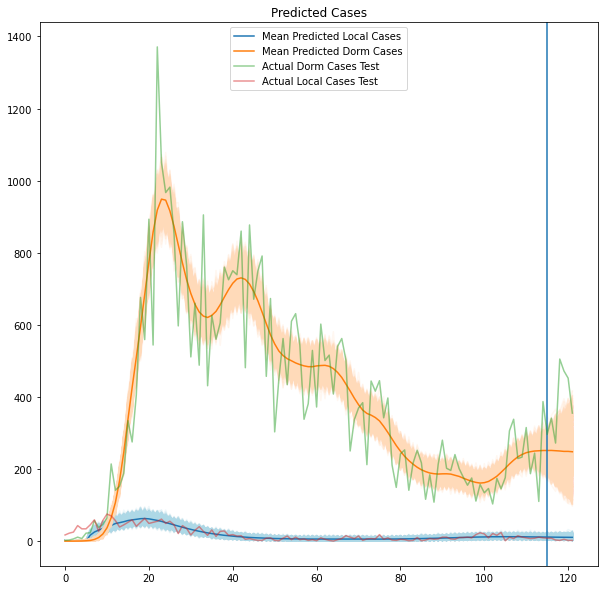

In [128]:
fig, ax = plt.subplots(figsize=(10,10))


#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax.plot(ppc_12['Obs_local'].T, c='lightblue', alpha=0.2)
ax.plot(ppc_12['Obs_local'].mean(0), alpha=1, label='Mean Predicted Local Cases')

ax.plot(ppc_12['Obs_dorm'].T, c='peachpuff', alpha=0.2)
ax.plot(ppc_12['Obs_dorm'].mean(0), alpha=1, label='Mean Predicted Dorm Cases')

# Actual cases
ax.axvline(x=end_date)
ax.plot(np.concatenate([train_dorm_only_cases, actual_dorm_only]), alpha=0.5, label='Actual Dorm Cases Test')
ax.plot(np.concatenate([train_local_only_cases, actual_local_only]), alpha=0.5, label='Actual Local Cases Test')

ax.legend()
ax.set_title("Predicted Cases")
plt.show()

In [1]:
fig, ax = plt.subplots(1,2, figsize=(20,10))


#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax[0].plot(ppc_12['Obs_local'].T, c='lightblue', alpha=0.2)
ax[0].plot(ppc_12['Obs_local'].mean(0), alpha=1, label='Mean Predicted Local Cases')

ax[1].plot(ppc_12['Obs_dorm'].T, c='peachpuff', alpha=0.2)
ax[1].plot(ppc_12['Obs_dorm'].mean(0), alpha=1, label='Mean Predicted Dorm Cases')

# Actual cases
ax[0].axvline(x=end_date)
ax[1].axvline(x=end_date)

ax[0].plot(np.concatenate([train_local_only_cases, actual_local_only]), alpha=0.5, label='Actual Local Cases Test')
ax[1].plot(np.concatenate([train_dorm_only_cases, actual_dorm_only]), alpha=0.5, label='Actual Dorm Cases Test')

ax[0].legend()
ax[1].legend()

ax[0].set_title("Predicted Cases - Local")
ax[1].set_title("Predicted Cases - Local")
plt.show()

NameError: name 'plt' is not defined

Plot latent infected and case counts for both dorm and local

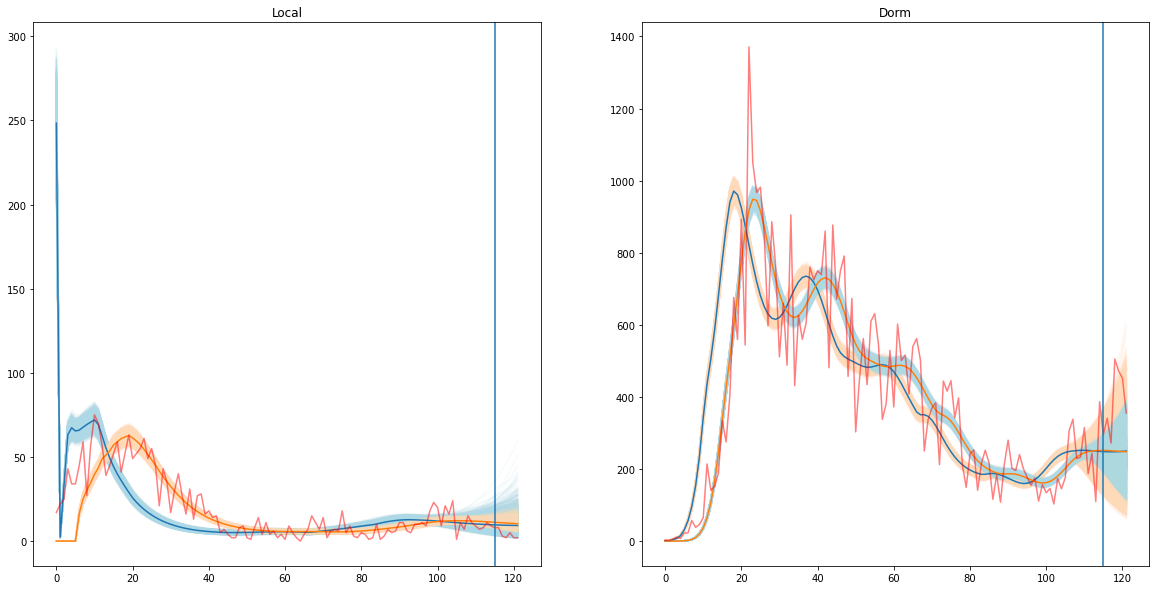

In [136]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(trace_12['infections_local'].T, c='lightblue', alpha=0.1)
ax[0].plot(trace_12['test_adjusted_positive_jit_local'].T, c='peachpuff', alpha=0.1)
ax[0].plot(trace_12['infections_local'].mean(0))
ax[0].plot(trace_12['test_adjusted_positive_jit_local'].mean(0))

ax[1].plot(trace_12['infections_dorm'].T, c='peachpuff', alpha=0.1)
ax[1].plot(trace_12['test_adjusted_positive_jit_dorm'].T, c='lightblue', alpha=0.1)
ax[1].plot(trace_12['infections_dorm'].mean(0))
ax[1].plot(trace_12['test_adjusted_positive_jit_dorm'].mean(0))


ax[0].plot(np.concatenate([train_local_only_cases, actual_local_only]), c='r', alpha=0.5)
ax[1].plot(np.concatenate([train_dorm_only_cases, actual_dorm_only]), c='r', alpha=0.5)
#ax.plot(imported_input, c='g')

ax[0].axvline(x=end_date)
ax[1].axvline(x=end_date)

ax[0].set_title('Local')
ax[1].set_title('Dorm')
plt.show()

Plot R_t

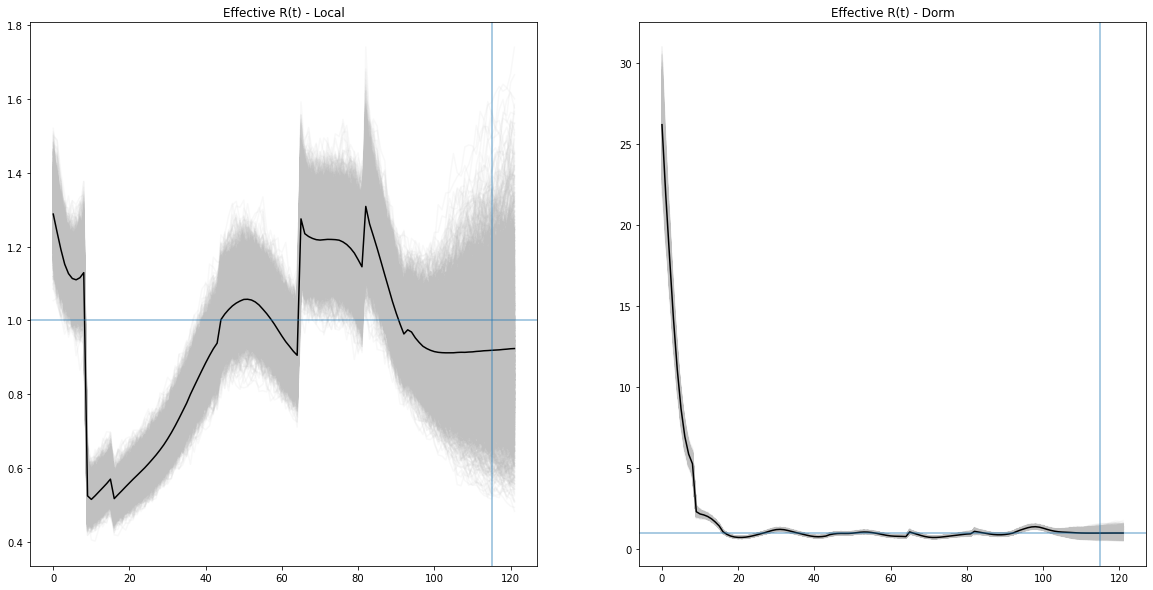

In [139]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(trace_12['r_t_local'].T, c='silver', alpha=0.1)
ax[0].plot(trace_12['r_t_local'].mean(0), c='black', alpha=1)
ax[0].axhline(y=1, alpha=0.5)
ax[0].axvline(x=end_date, alpha=0.5)
ax[0].set_title("Effective R(t) - Local")

ax[1].plot(trace_12['r_t_foreign'].T, c='silver', alpha=0.1)
ax[1].plot(trace_12['r_t_foreign'].mean(0), c='black', alpha=1)
ax[1].axhline(y=1, alpha=0.5)
ax[1].axvline(x=end_date, alpha=0.5)
ax[1].set_title("Effective R(t) - Dorm")

plt.show()

# Model 13.5
- lambda parameter for qurantine folks
- Plus alpha parameter for testing rate

In [167]:
import os

In [168]:
DATA_PATH1 = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_curve.csv')
DATA_PATH2 = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_split_curve.csv')
NPI_PATH = 'data/lockdown_index.csv'

In [171]:
dp1 = pd.read_csv(DATA_PATH1)
dp2 = pd.read_csv(DATA_PATH2)

In [172]:
x = dp2['Community Cases Detected through Surveillance'] + dp2['Community Cases Isolated before Detection']

In [173]:
np.all(dp1['Community Total Cases'] == x)

True

In [176]:
dp2.head()

,Unnamed: 0,Imported Cases Detected through Surveillance,Imported Cases Isolated before Detection,Community Cases Detected through Surveillance,Community Cases Isolated before Detection,DormResidents Detected through Surveillance,DormResidents Isolated before Detection,DormResidents(Prior to Classification on 24th Aug)
0,2020-01-23,1,0,0,0,0,0,0
1,2020-01-24,2,0,0,0,0,0,0
2,2020-01-25,1,0,0,0,0,0,0
3,2020-01-26,0,0,0,0,0,0,0
4,2020-01-27,1,0,0,0,0,0,0


In [44]:
p_delay_local_unq = p_delay_local
p_delay_q = np.array([0.001, 0.001, 0.001, 0.001, 0.5,0.5])

In [45]:
start_id = 400
end_date = 545

In [177]:
model_input_local_unqurantined = dp2['Community Cases Detected through Surveillance'].values[start_id:end_date]
model_input_local_qurantined = dp2['Community Cases Isolated before Detection'].values[start_id:end_date]

model_input_dorm_only = dp1['Dormitory Residents Total Cases'].values[start_id:end_date]
imported_cases = dp1['Imported Cases'].values[start_id:end_date]
len_observed = len(model_input_local_qurantined)

In [179]:
local_cases_data_path = '../covid19-modelling-sg/data/statistics/epidemic_split_curve.csv'
cases_breakdown = pd.read_csv(local_cases_data_path)

model_input_local_unqurantined = cases_breakdown['Community Cases Detected through Surveillance'].values[start_id:start_id+end_date]
model_input_local_qurantined = cases_breakdown['Community Cases Isolated before Detection'].values[start_id:start_id+end_date]

(162,)

In [60]:
NPIS_array

array([[0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       ...,
       [1.  , 0.  , 1.  , ..., 0.65, 0.5 , 0.25],
       [1.  , 0.  , 1.  , ..., 0.65, 0.5 , 0.25],
       [1.  , 0.  , 1.  , ..., 0.65, 0.5 , 0.25]])

In [61]:
NPIS_array = NPIS_array[:,1:]
NPIS_array = NPIS_array.astype('float')
num_NPIS = 10

In [62]:
(convolution_ready_gt[1].eval()).shape

(122,)

Get additional Covariates
- Qurantine Rate
- Testing Rate

In [87]:
!ls ..

 Data				      code
 Effective_Rt_quick_explanation.pdf   covid19-modelling-sg
 Images				      model_fit.PNG
 Model_Explanation.pdf		      p_delay.PNG
'Own Papers'			      r_t.PNG
'Project Papers'		      serial_interval.PNG
 Results


In [113]:
# Swab Rate
swab_fig_present = pd.read_csv('../covid19-modelling-sg/data/statistics/swab_figures.csv')
owid = pd.read_csv('../Data/owid-covid-data.csv')
singapore_test = owid[owid['location']=='Singapore']

In [114]:
singapore_test = singapore_test[['date','positive_rate',
                'total_tests',
                'new_tests',
                'new_cases',
                'tests_per_case']]

singapore_test['date'] = pd.to_datetime(singapore_test['date'])

- OWID: 2020-04-14 -> 2021-06-14
- Eugene: 2020-09-28 -> (2021-07-19) Today
- Earliest Date -> 2020-01-23

In [150]:
swab_fig_present['date'] = pd.to_datetime(swab_fig_present['date'])
swab_fig_present = swab_fig_present.groupby('date', as_index=False).first()

In [151]:
combined_swab_figs = singapore_test.merge(swab_fig_present, on='date', how='outer')

In [166]:
combined_swab_figs

,date,positive_rate,total_tests,new_tests,new_cases,tests_per_case,total_swabs_tested,average_daily_number_of_swabs_tested_over_the_past_week_approx,total_swabs_per_1m_total_population_approx
0,2020-01-23,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,2020-01-24,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
2,2020-01-25,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,2020-01-26,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,2020-01-27,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
510,2021-06-21,NaN,NaN,NaN,NaN,NaN,13287834.0,68400.0,2331200.0
511,2021-06-28,NaN,NaN,NaN,NaN,NaN,13607805.0,45700.0,2387300.0
512,2021-07-05,NaN,NaN,NaN,NaN,NaN,14116339.0,72600.0,2476600.0
513,2021-07-12,NaN,NaN,NaN,NaN,NaN,14751144.0,90700.0,2587900.0


In [162]:
combined_swab_figs.iloc[80:]

,date,positive_rate,total_tests,new_tests,new_cases,tests_per_case,total_swabs_tested,average_daily_number_of_swabs_tested_over_the_past_week_approx,total_swabs_per_1m_total_population_approx
80,2020-04-12,NaN,NaN,NaN,233.0,NaN,NaN,NaN,NaN
81,2020-04-13,NaN,NaN,NaN,386.0,NaN,NaN,NaN,NaN
82,2020-04-14,0.080,94796.0,NaN,334.0,12.5,NaN,NaN,NaN
83,2020-04-15,0.089,NaN,NaN,447.0,11.3,NaN,NaN,NaN
84,2020-04-16,0.102,NaN,NaN,728.0,9.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
510,2021-06-21,NaN,NaN,NaN,NaN,NaN,13287834.0,68400.0,2331200.0
511,2021-06-28,NaN,NaN,NaN,NaN,NaN,13607805.0,45700.0,2387300.0
512,2021-07-05,NaN,NaN,NaN,NaN,NaN,14116339.0,72600.0,2476600.0
513,2021-07-12,NaN,NaN,NaN,NaN,NaN,14751144.0,90700.0,2587900.0


In [64]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_12:
    
    # R_t Foreign
    log_r_t_foreign = pm.GaussianRandomWalk(
        'log_r_t_foreign',
        sigma=0.035,
        shape=len_observed)
    
    # R_t Local
    log_r_t_local = pm.GaussianRandomWalk(
        'log_r_t_local',
        sigma=0.035,
        shape=len_observed)
    
    """
    # NPI Covariates
    beta_list = []
    for i in range(num_NPIS):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = pm.math.dot(np.array(NPIS_array), betas)
    """
    rt_covariates = 0
    
    # Form r_t as GRW + covariates
    r_t_foreign = pm.Deterministic('r_t_foreign', pm.math.exp(log_r_t_foreign + rt_covariates))
    r_t_local = pm.Deterministic('r_t_local', pm.math.exp(log_r_t_local + rt_covariates))
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    
    # Infection Latent Dormitory
    seed_dorm = pm.Exponential('Seed_dorm', 150)  # Scale of infection will be small (Dorm cases started at 0)
    y0_dorm = tt.zeros(len_observed)
    y0_dorm = tt.set_subtensor(y0_dorm[0], seed_dorm)
    # Apply recursively to populate tensor
    outputs_dorm, _ = theano.scan(
            fn=lambda t, gt , y, r_t_foreign: tt.set_subtensor(y[t], tt.sum(r_t_foreign*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0_dorm,
            non_sequences=r_t_foreign,
            n_steps=len_observed-1,
    )
    infections_dorm = pm.Deterministic('infections_dorm', outputs_dorm[-1])
    
    
    # Qurantine randomwalk
    log_lambda_t = pm.GaussianRandomWalk(
        'log_lambda_t',
        sigma=0.035,
        shape=len_observed)
    
    lambda_t = pm.Deterministic('Q Rate', pm.math.sigmoid(log_lambda_t))
    
    
    # Infection Latent Local only
    seed = pm.Exponential('Seed_local', 1)  # Scale of infection will be small (Local cases were quite high already)
    y0_local = tt.zeros(len_observed)
    y0_local = tt.set_subtensor(y0_local[0], seed)
    # Apply recursively to populate tensor
    outputs_local, _ = theano.scan(
            fn=lambda t, gt, i_cases, l_t, y, r_t_local: tt.set_subtensor(y[t], l_t*(tt.sum(r_t_local*y*gt) + eps_t * i_cases)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_cases), lambda_t],
            outputs_info=y0_local,
            non_sequences=[r_t_local],
            n_steps=len_observed-1,
    )
    
    
    infections_local = pm.Deterministic('infections_local_uncontained', outputs_local[-1])
    q_lambda_t = pm.Deterministic('infections_rate', (1-lambda_t)/lambda_t)
    
    infections_local_contained = pm.Deterministic('infections_local_contained', q_lambda_t*infections_local)
    
    # alpha Parameter - determines test rates from 3 sources
    # Dorm
    log_alpha_dorm_t = pm.GaussianRandomWalk(
        'log_alpha_dorm_t',
        sigma=0.035,
        shape=len_observed)
    alpha_dorm_t = pm.Deterministic('alpha_dorm_t', pm.math.sigmoid(log_alpha_dorm_t))
    
    # Local - UnQ
    log_alpha_unQ_t = pm.GaussianRandomWalk(
        'log_alpha_unQ_t',
        sigma=0.035,
        shape=len_observed)
    alpha_unQ_t = pm.Deterministic('alpha_local_unQ_t', pm.math.sigmoid(log_alpha_unQ_t))
    
    # Local - UnQ
    log_alpha_Q_t = pm.GaussianRandomWalk(
        'log_alpha_Q_t',
        sigma=0.035,
        shape=len_observed)
    alpha_Q_t = pm.Deterministic('alpha_local_Q_t', pm.math.sigmoid(log_alpha_Q_t))
    
    
    
    # Onset - Delay Dist - Local
    t_p_delay_local = pm.Data("p_delay_local", p_delay_local)
    
    # Onset - Delay Dist - Qurantine
    t_p_delay_local_q = pm.Data('p_delay_local_qurantine', p_delay_q)
    
    # Onset - Delay Dist - Dorm
    t_p_delay_dorm = pm.Data("p_delay_dorm", pd.Series(p_delay_dorm))
    
    
    # Test adjusted positive - Local
    test_adjusted_positive_local = pm.Deterministic(
        "test adjusted positive local",
        conv(infections_local, t_p_delay_local, len(p_delay), len_observed)
    )
    test_adjusted_positive_jittered_local = pm.Deterministic('test_adjusted_positive_jit_local',
                                                   alpha_unQ_t*test_adjusted_positive_local + 0)
    
    
    # Test adjusted positive - Local Qurantined
    test_adjusted_positive_local_qurantined = pm.Deterministic(
        "test adjusted positive local Qurantined",
        conv(infections_local_contained, t_p_delay_local_q, len(p_delay_q), len_observed)
    )
    test_adjusted_positive_jittered_local_qurantined = pm.Deterministic('test_adjusted_positive_jit_local_qurantined',
                                                   alpha_Q_t*test_adjusted_positive_local_qurantined + 0)
    
    # Test adjusted Positive - Dorm
    test_adjusted_positive_dorm = pm.Deterministic(
        "test adjusted positive dorm",
        conv(infections_dorm, t_p_delay_dorm, len(pd.Series(p_delay_dorm)), len_observed)
    )   

    test_adjusted_positive_jittered_dorm = pm.Deterministic('test_adjusted_positive_jit_dorm',
                                                   alpha_dorm_t*test_adjusted_positive_dorm + 0)
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs_local', 
                  mu=test_adjusted_positive_jittered_local,
                  observed=model_input_local_unqurantined)
        
        pm.Poisson('Obs_local_q', 
                  mu=test_adjusted_positive_local_qurantined,
                  observed=model_input_local_qurantined)
        
        pm.Poisson('Obs_dorm', 
                  mu=test_adjusted_positive_jittered_dorm,
                  observed=model_input_dorm_only)
    
    trace_12 = pm.sample(chains=2,
                         tune=1000,
                         draws=2000)
                         #target_accept=0.99,
                         #init="adapt_diag"
                        ##,nuts={'target_accept':0.99})#, target_accept=0.99)

hi


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_alpha_Q_t, log_alpha_unQ_t, log_alpha_dorm_t, Seed_local, log_lambda_t, Seed_dorm, eps_t, log_eps_t, log_r_t_local, log_r_t_foreign]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11848 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6810444625062361, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:>

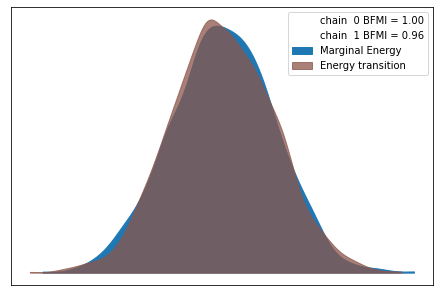

In [70]:
az.plot_energy(trace_12)

### Plot Walks
- Re(t)
- alpha_t (dorm/local_Q/local_unQ)
- Qurantine rate

In [81]:
trace_12.varnames

['log_r_t_foreign',
 'log_r_t_local',
 'log_eps_t',
 'eps_t_logodds__',
 'Seed_dorm_log__',
 'log_lambda_t',
 'Seed_local_log__',
 'log_alpha_dorm_t',
 'log_alpha_unQ_t',
 'log_alpha_Q_t',
 'r_t_foreign',
 'r_t_local',
 'eps_t',
 'Seed_dorm',
 'infections_dorm',
 'Q Rate',
 'Seed_local',
 'infections_local_uncontained',
 'infections_rate',
 'infections_local_contained',
 'alpha_dorm_t',
 'alpha_local_unQ_t',
 'alpha_local_Q_t',
 'test adjusted positive local',
 'test_adjusted_positive_jit_local',
 'test adjusted positive local Qurantined',
 'test_adjusted_positive_jit_local_qurantined',
 'test adjusted positive dorm',
 'test_adjusted_positive_jit_dorm']

Text(0.5, 1.0, 'Alpha(t) - Q')

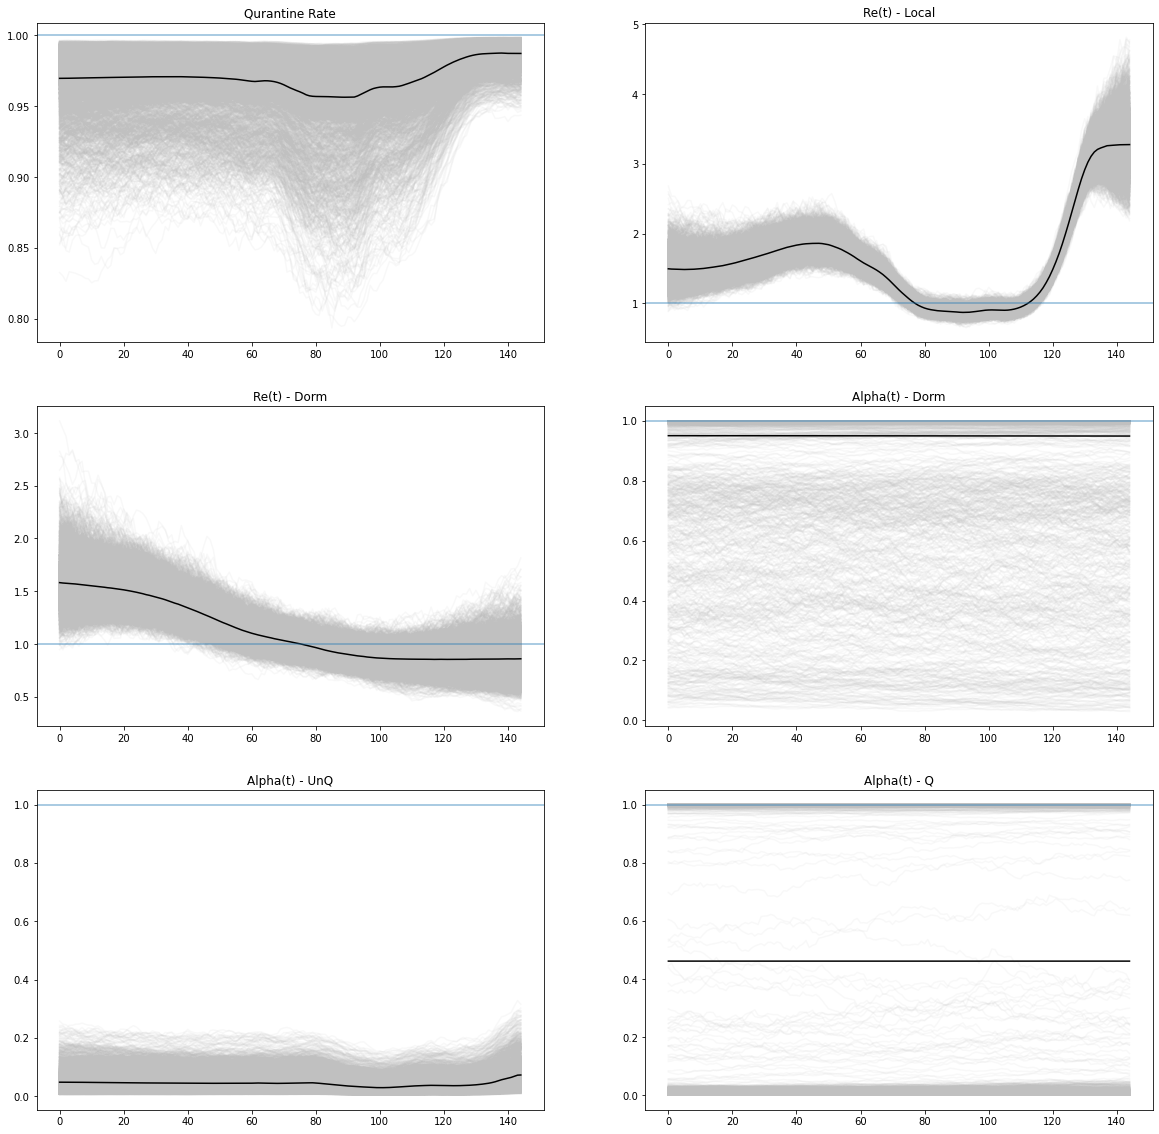

In [82]:
fig, ax = plt.subplots(3,2,figsize=(20,20))

ax[0,0].plot(trace_12['Q Rate'].T, c='silver', alpha=0.1)
ax[0,0].plot(trace_12['Q Rate'].mean(0), c='black', alpha=1)
ax[0,0].axhline(y=1, alpha=0.5)
ax[0,0].set_title('Qurantine Rate')

ax[0,1].plot(trace_12['r_t_local'].T, c='silver', alpha=0.1)
ax[0,1].plot(trace_12['r_t_local'].mean(0), c='black', alpha=1)
ax[0,1].axhline(y=1, alpha=0.5)
ax[0,1].set_title('Re(t) - Local')

ax[1,0].plot(trace_12['r_t_foreign'].T, c='silver', alpha=0.1)
ax[1,0].plot(trace_12['r_t_foreign'].mean(0), c='black', alpha=1)
ax[1,0].axhline(y=1, alpha=0.5)
ax[1,0].set_title('Re(t) - Dorm')

ax[1,1].plot(trace_12['alpha_dorm_t'].T, c='silver', alpha=0.1)
ax[1,1].plot(trace_12['alpha_dorm_t'].mean(0), c='black', alpha=1)
ax[1,1].axhline(y=1, alpha=0.5)
ax[1,1].set_title('Alpha(t) - Dorm')

ax[2,0].plot(trace_12['alpha_local_unQ_t'].T, c='silver', alpha=0.1)
ax[2,0].plot(trace_12['alpha_local_unQ_t'].mean(0), c='black', alpha=1)
ax[2,0].axhline(y=1, alpha=0.5)
ax[2,0].set_title('Alpha(t) - UnQ')

ax[2,1].plot(trace_12['alpha_local_Q_t'].T, c='silver', alpha=0.1)
ax[2,1].plot(trace_12['alpha_local_Q_t'].mean(0), c='black', alpha=1)
ax[2,1].axhline(y=1, alpha=0.5)
ax[2,1].set_title('Alpha(t) - Q')


#ax.axvline(x=end_date, alpha=0.5)
#ax[0].set_title("Effective R(t) - Local")

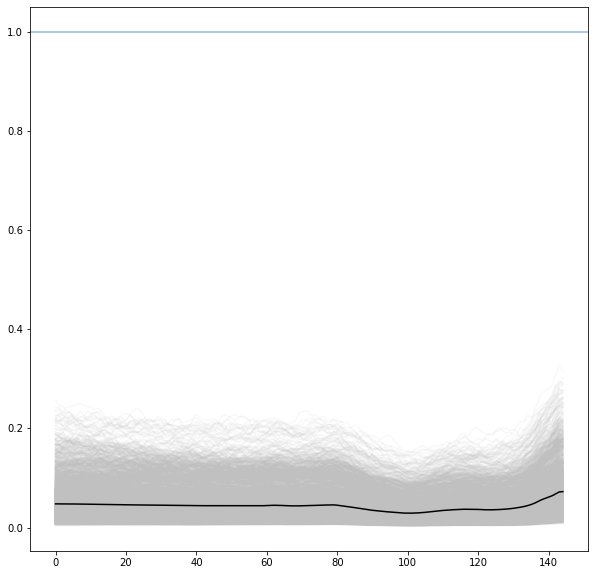

In [74]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_12['alpha_local_unQ_t'].T, c='silver', alpha=0.1)
ax.plot(trace_12['alpha_local_unQ_t'].mean(0), c='black', alpha=1)
ax.axhline(y=1, alpha=0.5)
#ax.axvline(x=end_date, alpha=0.5)
#ax[0].set_title("Effective R(t) - Local")

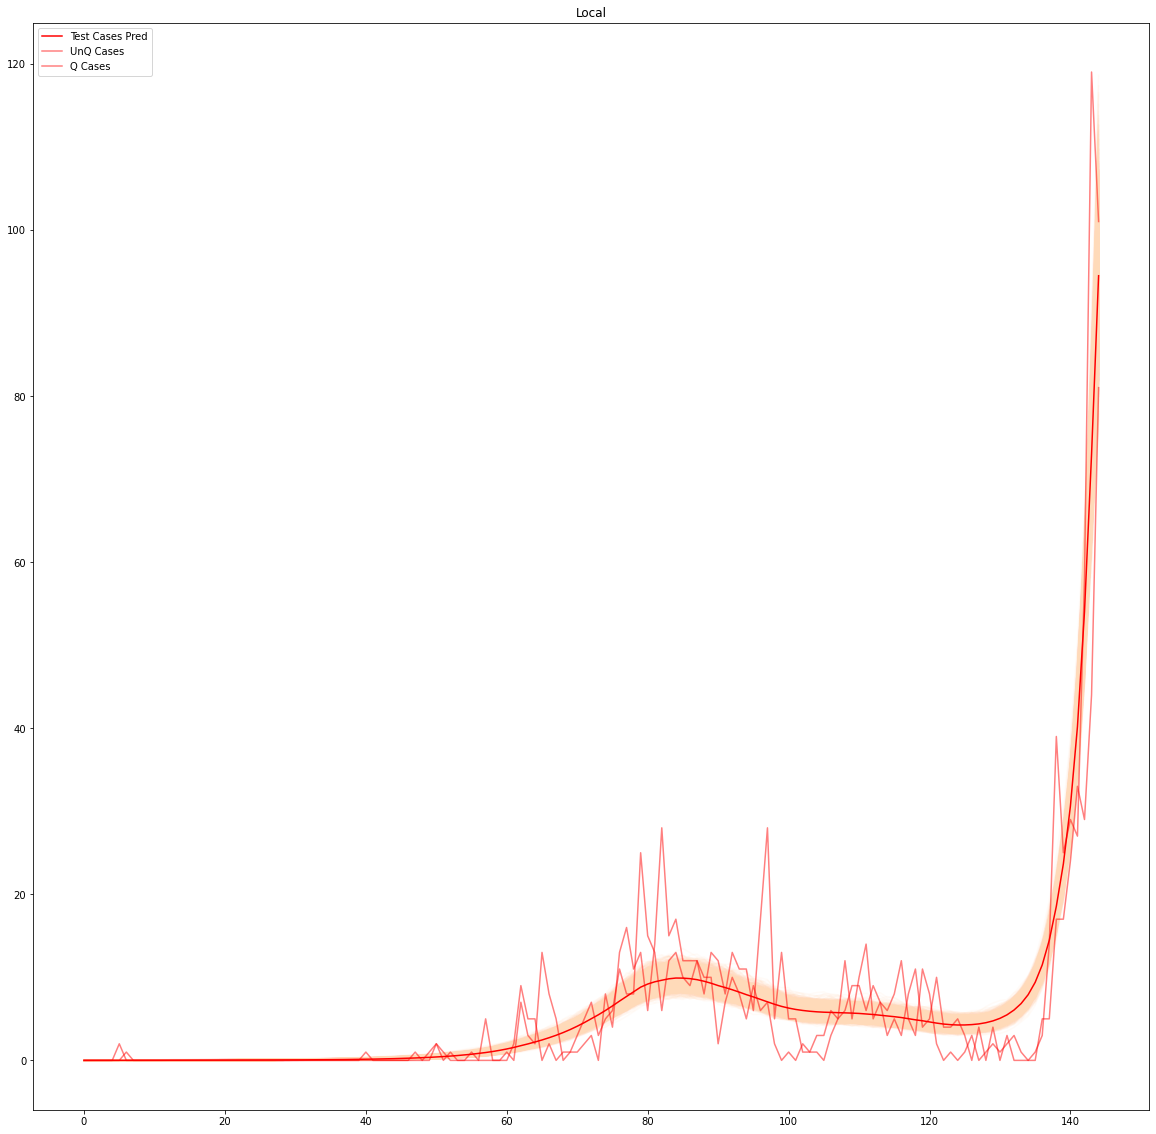

In [85]:
fig, ax = plt.subplots( figsize=(20,20))

#ax.plot(trace_12['infections_local_uncontained'].T, c='lightblue', alpha=0.1)
ax.plot(trace_12['test_adjusted_positive_jit_local'].T, c='peachpuff', alpha=0.1)
#ax.plot(trace_12['infections_local_uncontained'].mean(0), label='Infections')
ax.plot(trace_12['test_adjusted_positive_jit_local'].mean(0),c='red', label='Test Cases Pred')

ax.plot((model_input_local_unqurantined), c='r', alpha=0.5,label='UnQ Cases')
ax.plot((model_input_local_qurantined), c='r', alpha=0.5,label='Q Cases')
#ax.plot(imported_input, c='g')


#ax[0].axvline(x=end_date)
#ax[1].axvline(x=end_date)

ax.set_title('Local')
ax.legend()
plt.show()

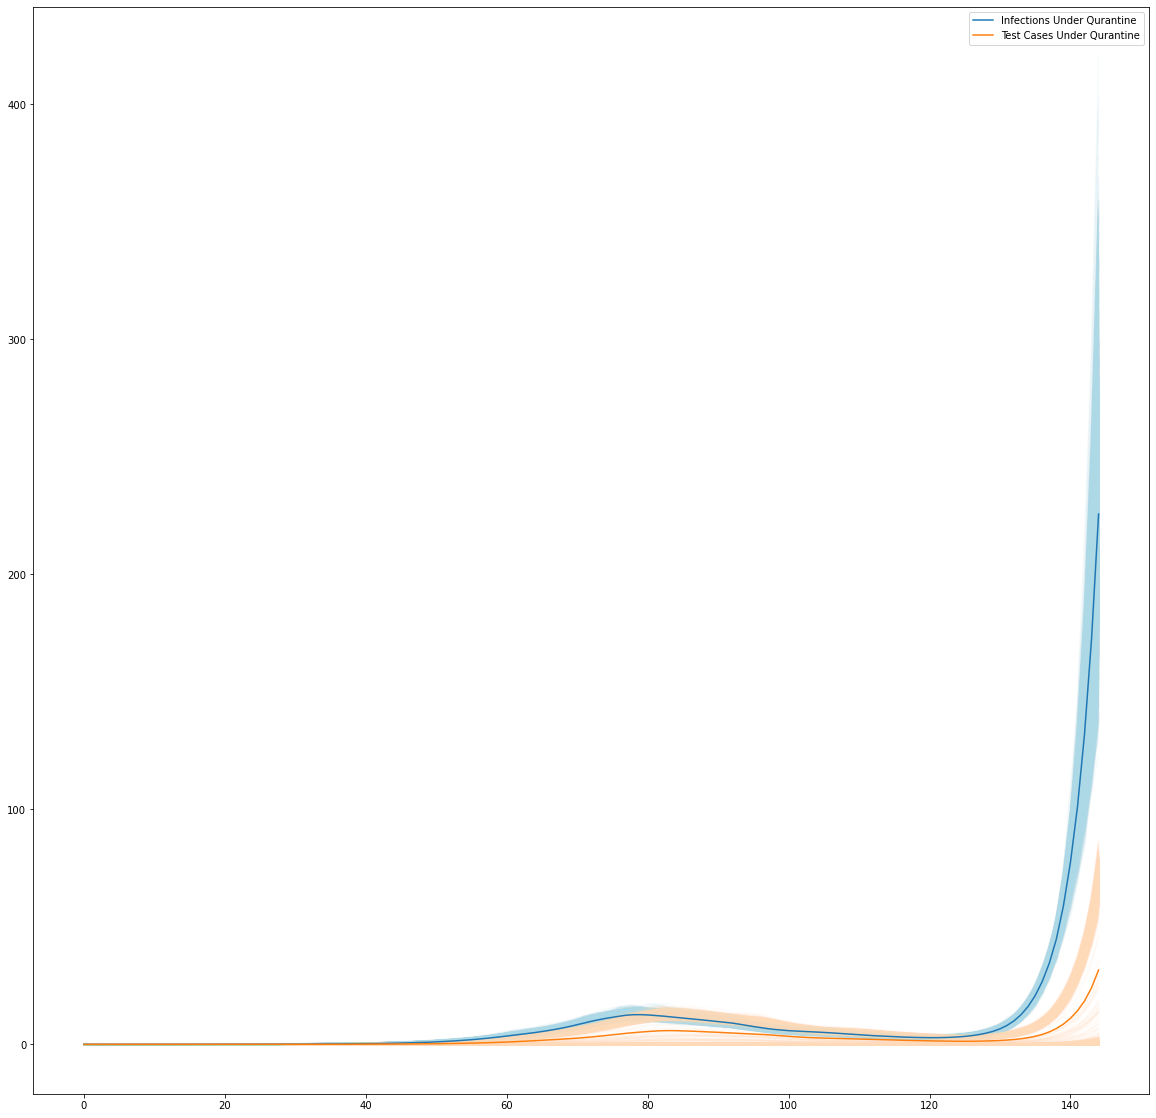

In [78]:
fig, ax = plt.subplots( figsize=(20,20))

ax.plot(trace_12['infections_local_contained'].T, c='lightblue', alpha=0.1)
ax.plot(trace_12['test_adjusted_positive_jit_local_qurantined'].T, c='peachpuff', alpha=0.1)
ax.plot(trace_12['infections_local_contained'].mean(0), label='Infections Under Qurantine')
ax.plot(trace_12['test_adjusted_positive_jit_local_qurantined'].mean(0), label='Test Cases Under Qurantine')

#ax.plot((model_input_local_unqurantined), c='r', alpha=0.5,label='UnQ Cases')
#ax.plot((model_input_local_qurantined), c='r', alpha=0.5,label='Q Cases')
ax.legend()
#ax.plot(imported_input, c='g')

Testing as N in binomial

In [176]:
"""
narrative_ids: the narrative id list
scfa_val: scfa value for which to create fake data
"""

['log_r_t_foreign',
 'log_r_t_local',
 'log_eps_t',
 'eps_t_logodds__',
 'Seed_dorm_log__',
 'log_lambda_t',
 'Seed_local_log__',
 'r_t_foreign',
 'r_t_local',
 'eps_t',
 'Seed_dorm',
 'infections_dorm',
 'Q Rate',
 'Seed_local',
 'infections_local_uncontained',
 'infections_rate',
 'infections_local_contained',
 'test adjusted positive local',
 'test_adjusted_positive_jit_local',
 'test adjusted positive local Qurantined',
 'test_adjusted_positive_jit_local_qurantined',
 'test adjusted positive dorm',
 'test_adjusted_positive_jit_dorm']

- Append multi trace
- Extend x by one more -> And sample more -> and prior
- Add samples to the trace

- 

In [ ]:
model_input_local_unqurantined = dp2['Community Cases Detected through Surveillance'].values[start_id:end_date]
model_input_local_qurantined

In [ ]:
        """
        adjust output to absolute change starting from loaded personas in AW persona (or whatever is initialized)
        
        return_type: 'normal', 'abs_change', 'abs_change_adjusted'
        """



# Model 14
- First model to incorporate the effect of quarantine as well as vaccination rates

# Model 15
- Time varying onset - delay and generation times.

# Model 16
- Non deterministic latent infected to account for super spreader events

# Model Comparison

In [250]:
az.compare({
    'Simplest': trace_1,
    'Only Generation Time':trace_2,
    'Generation Time + RT NPI Coavariates': trace_4,
    'Generation Time + RT NPI Coavariates + Zero inflated': trace_5})

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packa

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Generation Time + RT NPI Coavariates,0,-1570.659773,19.777704,0.000000,9.978604e-01,52.305803,0.000000,False,log
Only Generation Time,1,-1570.998389,19.806806,0.338616,5.104432e-16,52.358256,0.234655,False,log
Generation Time + RT NPI Coavariates + Zero inflated,2,-1572.678688,19.569732,2.018915,0.000000e+00,52.375470,0.263122,True,log
Simplest,3,-2485.798618,1.570142,915.138845,2.139620e-03,64.905321,24.499392,False,log


In [218]:
az.compare({
    '8': trace_8,
    '9 Generation Time':trace_9})

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-r

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
9 Generation Time,0,-4067.774371,373.320698,0.00000,0.877024,561.862781,0.000000,True,log
8,1,-107067.348142,351.332064,102999.57377,0.122976,4415.565236,4543.822939,True,log


In [239]:
az.compare({
    'Simplest': trace_8,
    'Only Generation Time':trace_2,
    'Generation + Onset': trace_3
})

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packa

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Only Generation Time,0,-1570.998389,19.806806,0.000000,0.977460,52.358256,0.000000,False,log
Generation + Onset,1,-1572.940396,18.952800,1.942006,0.020307,52.536873,1.637805,False,log
Simplest,2,-2485.798618,1.570142,914.800229,0.002233,64.905321,24.543604,False,log


# Generic Visualization Tools

In [719]:
trace = trace_11
start_id = 0

In [716]:
trace.varnames

['log_r_t',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'b_6',
 'b_7',
 'b_8',
 'b_9',
 'log_eps_t',
 'eps_t_logodds__',
 'Seed_log__',
 'r_t',
 'eps_t',
 'Seed',
 'infections',
 'test adjusted positive',
 'test_adjusted_positive_jit']

In [717]:
data_subset = data.iloc[start_id::,:]
data_subset['t'] = range(len_observed)
phase_info = data_subset[['Phase', 't']]

def get_intervals(days_in_phase):

    interval_track = []
    cnt = 0
    c = days_in_phase['t'].iloc[0]
    start = c

    for i in range(len(days_in_phase)):

        if days_in_phase['t'].iloc[cnt] != c:

            interval_track.append((start, days_in_phase['t'].iloc[cnt-1]))
            c = days_in_phase['t'].iloc[cnt]  # reset c
            start = c

        c += 1 
        cnt += 1

    interval_track.append((start, days_in_phase['t'].iloc[cnt-1]))
    
    return interval_track

phase_times = {}
for ph in phase_info['Phase'].unique():
    if pd.isna(ph):
        continue
    
    else: 
        days_in_phase = phase_info[phase_info['Phase']==ph]
        
        # Check if disjoint
        days_elapsed = days_in_phase['t'].iloc[-1] - days_in_phase['t'].iloc[0] +1
        
        if days_elapsed == len(days_in_phase):
            # Not disjoint
            start = days_in_phase['t'].iloc[0]
            end = days_in_phase['t'].iloc[-1]
            phase_times[ph] = [(start, end)]
        
        else: 
            phase_times[ph] = get_intervals(days_in_phase)
            

ValueError: Length of values (115) does not match length of index (498)

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:>

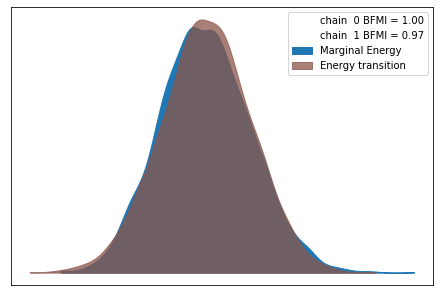

In [720]:
az.plot_energy(trace)

In [222]:
col_list = ['red','blue','green','orange','purple']
phase_times


{'Circuit Breaker': [(25, 80)],
 'Phase 1': [(81, 97)],
 'Phase 2': [(98, 289), (421, 428)],
 'Phase 3': [(290, 420)],
 'Phase 2 (Heightened Alert)': [(429, 447)]}

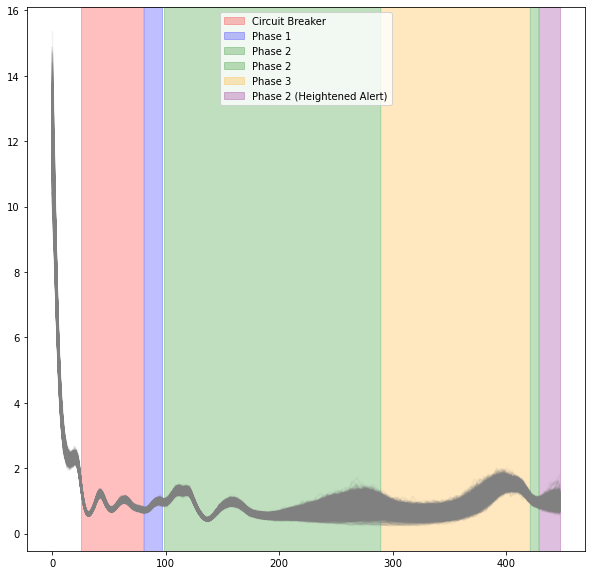

In [223]:
post_rt = trace.get_values('r_t', burn=0, chains=[0])
post_rt = pd.DataFrame(post_rt.T)

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(post_rt, color='0.5', alpha=0.1)

for col, ph in enumerate(phase_times.keys()):
    p_time = phase_times[ph]
    
    for times in p_time:
        ax.axvspan(times[0], times[1],
                   color=col_list[col],
                   alpha=0.25,
                   label=ph)
ax.legend()
plt.show()

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


[]

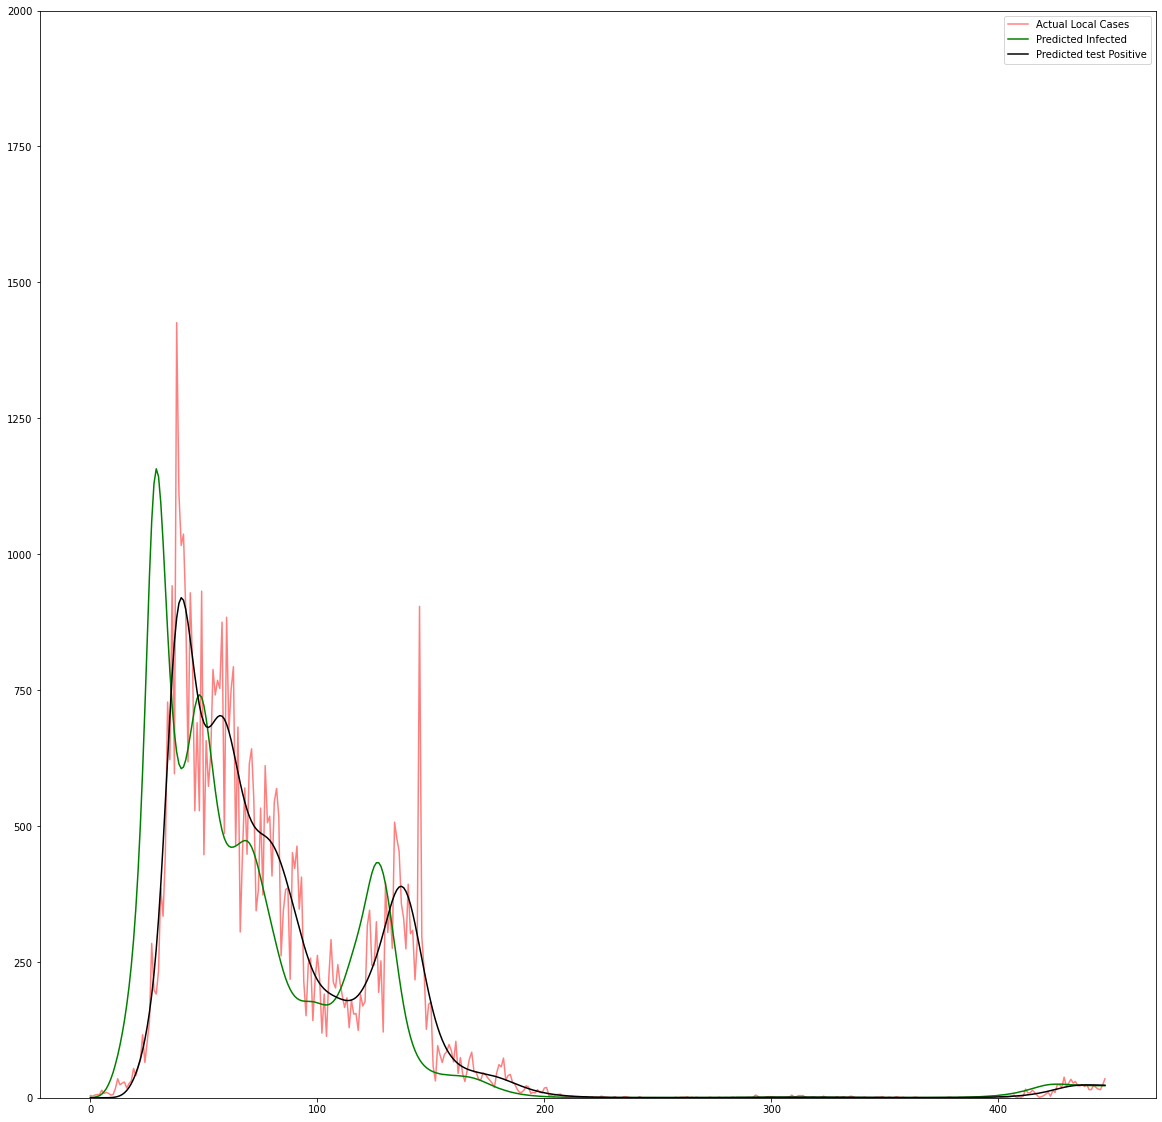

In [225]:
with model_9:
    post_pred_r_t = pm.sample_posterior_predictive(trace,
                                                   samples=1000)

SHOW_PHASES = False
SCALE = False 
fig, ax = plt.subplots(figsize=(20,20))

if SCALE:
    #ax.plot(post_pred_r_t['Obs'].T, color='0.5', alpha=0.02)
    ax.plot(local_cases, color='r', label='Actual Local Cases', alpha=0.5)
    ax.plot(scale_to_positives(local_cases, trace['infections'].mean(0)), color='g', label='Predicted Infected')
    #ax.plot(trace['positive'].mean(0), color='b', label='Predicted Constant test Positive')
    ax.plot(scale_to_positives(local_cases, trace['test adjusted positive'].mean(0)), color='k', label='Predicted test Positive')

else:
    #ax.plot(post_pred_r_t['Obs'].T, color='0.5', alpha=0.02)
    ax.plot(local_cases, color='r', label='Actual Local Cases', alpha=0.5)
    ax.plot(trace['infections'].mean(0), color='g', label='Predicted Infected')
    #ax.plot(trace['positive'].mean(0), color='b', label='Predicted Constant test Positive')
    ax.plot(trace['test adjusted positive'].mean(0), color='k', label='Predicted test Positive')

if SHOW_PHASES:
    for col, ph in enumerate(phase_times.keys()):
        p_time = phase_times[ph]

        for times in p_time:
            ax.axvspan(times[0], times[1],
                       color=col_list[col],
                       alpha=0.15,
                       label=ph)
ax.legend()
ax.set_ylim([0,2000])
plt.plot()

<AxesSubplot:>

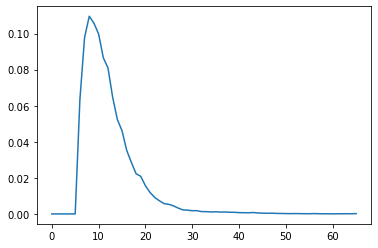

In [80]:
p_delay.plot()

In [208]:
p_delay

0     0.000100
1     0.000100
2     0.000100
3     0.000100
4     0.000100
        ...   
61    0.000078
62    0.000098
63    0.000117
64    0.000078
65    0.000163
Name: p_delay, Length: 66, dtype: float64

In [78]:
local_cases[50:]

array([447, 657, 573, 632, 788, 741, 768, 753, 875, 486, 884, 675, 752,
       793, 465, 682, 305, 451, 570, 448, 614, 642, 548, 344, 383, 533,
       373, 611, 506, 518, 408, 544, 569, 517, 261, 344, 383, 386, 218,
       451, 422, 463, 347, 406, 214, 151, 247, 257, 142, 218, 262, 218,
       119, 191, 113, 219, 291, 213, 202, 245, 211, 187, 166, 184, 129,
       180, 154, 155, 124, 190, 169, 177, 317, 345, 244, 244, 324, 194,
       252, 121, 396, 304, 349, 275, 507, 477, 454, 357, 330, 274, 393,
       302, 308, 217, 288, 904, 297, 236, 126, 172, 176,  58,  31,  96,
        79,  65,  80,  85,  98,  87,  66, 104,  45,  74,  44,  30,  50,
        72,  84,  48,  47,  34,  33,  46,  43,  37,  32,  27,  19,  46,
        61,  57,  73,  32,  41,  43,  28,  25,  16,  10,  10,  14,  22,
        20,   8,  10,   9,  15,  10,   9,  18,  19,   4,   5,   2,   6,
         6,   7,   4,   4,   1,   2,   3,   2,   0,   2,   1,   1,   2,
         2,   0,   2,   0,   1,   0,   3,   2,   1,   1,   0,   

In [554]:
tests_performed

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
      

In [468]:
scale_to_positives(local_cases, trace['infections'].mean(0))[0]

15411.805545775449

# If Covariates

In [253]:
az.summary(trace,[ 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_inter'])

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_0,-0.006,0.030,-0.061,0.054,0.001,0.001,1840.0,1469.0,1.0
b_1,-0.011,0.029,-0.070,0.040,0.001,0.001,2322.0,1862.0,1.0
b_2,0.019,0.030,-0.036,0.076,0.001,0.001,891.0,1211.0,1.0
b_3,-0.015,0.030,-0.070,0.041,0.001,0.001,2603.0,1362.0,1.0
b_4,0.004,0.029,-0.052,0.056,0.001,0.001,1835.0,1697.0,1.0
b_inter,-0.000,0.030,-0.059,0.054,0.002,0.001,317.0,565.0,1.0


In [252]:
trace.varnames

['log_r_t',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_inter',
 'Seed_log__',
 'alpha_log__',
 'r_t',
 'Seed',
 'infections',
 'alpha']

In [451]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

In [452]:
df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [453]:


region = "OR"
model_data = df.loc[region]



<AxesSubplot:xlabel='date'>

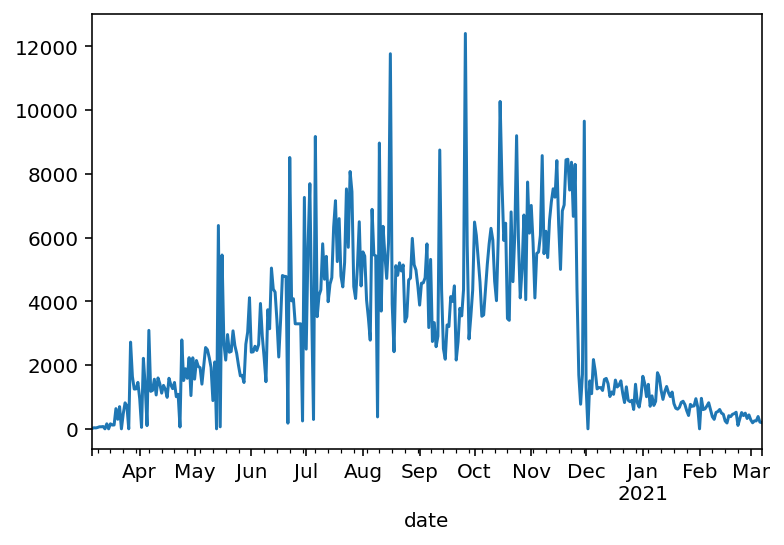

In [457]:
model_data['total'].plot()

In [461]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1577 seconds.


0, dim: nonzero_date, 358 =? 358


In [76]:
def scale_to_positives(positive_cases, data):
    
    """ Scales a time series to have the same mean as the observed positives
        time series. This is useful because many of the series we infer are
        relative to their true values so we make them comparable by putting
        them on the same scale. """
    
    scale_factor = positive_cases.mean() / np.mean(data)
    return scale_factor * data